In [76]:
import os
import numpy as np
import tensorflow as tf
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
import math
from sklearn.manifold import TSNE,Isomap
from sklearn.model_selection import StratifiedKFold

import warnings
warnings.filterwarnings("ignore")

tf.config.experimental.set_visible_devices([], 'GPU')

In [78]:
def visualize_latent_space(z_mu_list,label_list):

    # cannot work on full training samples so get a small and stratified portion
    skf = StratifiedKFold(n_splits=20)
    for _, test_index in skf.split(z_mu_list, label_list):
        mini_z_mu_list, mini_label_list = z_mu_list[test_index], label_list[test_index]
        break

    tsne = TSNE(n_jobs=-1,learning_rate='auto',init='pca')
    embedded_mus = tsne.fit_transform(mini_z_mu_list)

    df = pd.DataFrame({'dim1':embedded_mus[:,0],'dim2':embedded_mus[:,1],'label':mini_label_list})
    fig = plt.figure(figsize=(8, 8))
    sns_plot = sns.scatterplot(data=df, x="dim1", y="dim2", hue="label",palette='bright')
    sns_plot.figure.savefig("results/tsne_transformed_latent_space.png") 

    return

In [79]:
def get_encoder(latent_dim):
    inputs = tf.keras.Input(shape = (10000,))
    x = tf.keras.layers.Dense(units=5000, activation='relu')(inputs)
    x = tf.keras.layers.Dense(units=1200, activation='relu')(x)
    mu = tf.keras.layers.Dense(units=latent_dim)(x)
    rho = tf.keras.layers.Dense(units=latent_dim)(x)
    Encoder = tf.keras.Model(inputs=inputs,outputs=[mu,rho])
    
    return Encoder

def get_decoder(latent_dim):
    z = tf.keras.Input(shape = (latent_dim,))
    x = tf.keras.layers.Dense(units=1200, activation='relu')(z)
    x = tf.keras.layers.Dense(units=5000, activation='relu')(x)
    decoded_img = tf.keras.layers.Dense(units=10000)(x)
    Decoder = tf.keras.Model(inputs=z,outputs=[decoded_img])
    
    return Decoder

class VAE(tf.keras.Model):
    def __init__(self,latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder_block = get_encoder(latent_dim)
        self.decoder_block = get_decoder(latent_dim)

    def call(self,img):
        z_mu,z_rho = self.encoder_block(img)

        epsilon = tf.random.normal(shape=z_mu.shape,mean=0.0,stddev=1.0)
        z = z_mu + tf.math.softplus(z_rho) * epsilon
        
        decoded_img = self.decoder_block(z)

        return z_mu,z_rho,decoded_img

In [80]:
def _flatten(sample):
    array = tf.reshape(sample,[-1])
    return array

def prepare_data(dataset_name):
    train_dataset = tf.data.Dataset.load("../dataset/m1_ssRNA_train_" + dataset_name)
    test_dataset = tf.data.Dataset.load("../dataset/m1_ssRNA_test_" + dataset_name)
    input_shape = train_dataset.element_spec[0].shape
    train_dataset = (train_dataset
                     .shuffle(int(10e3))
                     .map(lambda data, label: (_flatten(data), label))
                     .batch(5)
                     .prefetch(tf.data.AUTOTUNE))
    test_dataset = (test_dataset
                    .shuffle(int(10e3))
                    .map(lambda data, label: (_flatten(data), label))
                    .batch(5)
                    .prefetch(tf.data.AUTOTUNE))
    # check size of dataset
    print(f'train: {train_dataset.cardinality().numpy()}')
    print(f'test: {test_dataset.cardinality().numpy()}')
    return train_dataset, test_dataset

# closed form kl loss computation between variational posterior q(z|x) and unit Gaussian prior p(z) 
def kl_loss(z_mu,z_rho):
    sigma_squared = tf.math.softplus(z_rho) ** 2
    kl_1d = -0.5 * (1 + tf.math.log(sigma_squared) - z_mu ** 2 - sigma_squared)

    # sum over sample dim, average over batch dim
    kl_batch = tf.reduce_mean(tf.reduce_sum(kl_1d,axis=1))

    return kl_batch

def elbo(z_mu,z_rho,decoded_img,original_img):
    # reconstruction loss
    mse = tf.reduce_mean(tf.reduce_sum(tf.square(original_img - decoded_img),axis=1))
    # kl loss
    kl = kl_loss(z_mu,z_rho)

    return mse,kl

def train(latent_dim,beta,epochs,train_ds):#,x_test,dataset_mean,dataset_std):

    model = VAE(latent_dim)

    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)

    kl_loss_tracker = tf.keras.metrics.Mean(name='kl_loss')
    mse_loss_tracker = tf.keras.metrics.Mean(name='mse_loss')


    for epoch in range(epochs):

        label_list = None
        z_mu_list = None    

        for _,(imgs,labels) in train_ds.enumerate():
            
            # training loop
            with tf.GradientTape() as tape:
                # forward pass
                z_mu,z_rho,decoded_imgs = model(imgs)

                # compute loss
                mse,kl = elbo(z_mu,z_rho,decoded_imgs,imgs)
                loss = mse + beta * kl
            
            # compute gradients
            gradients = tape.gradient(loss,model.variables)

            # update weights
            optimizer.apply_gradients(zip(gradients, model.variables))

            # update metrics
            kl_loss_tracker.update_state(beta * kl)
            mse_loss_tracker.update_state(mse)

            # save encoded means and labels for latent space visualization
            if label_list is None:
                label_list = labels
            else:
                label_list = np.concatenate((label_list,labels))
                
            if z_mu_list is None:
                z_mu_list = z_mu
            else:
                z_mu_list = np.concatenate((z_mu_list,z_mu),axis=0)


        # visualize the latent space by non-linear dim reduction
        visualize_latent_space(z_mu_list,label_list)

        # display metrics at the end of each epoch.
        epoch_kl,epoch_mse = kl_loss_tracker.result(),mse_loss_tracker.result()
        print(f'epoch: {epoch}, mse: {epoch_mse:.4f}, kl_div: {epoch_kl:.4f}')

        # reset metric states
        kl_loss_tracker.reset_state()
        mse_loss_tracker.reset_state()

    return

train: 182
test: 21
[[-0.80609965  0.90293545]
 [-0.6924827   0.7563957 ]
 [-0.50678694  0.40396437]
 ...
 [-1.9300328   4.3755193 ]
 [ 0.82336193  4.4432616 ]
 [-0.42856598  4.4557695 ]]
[ 7  3 10  1  2  4  5  9  1  1  4  4  3  1  2  2  3  6  8  8 10  3  1  4
  7  2  9  9  8  3  8  8  1 10  7  9  8  2  5  5  1  6  7  1  2  3 10  7
  9  1  6  2 10  4  2  4  7  5  9  3  9 10  3  5  1  8  4  6 10  8  3  1
  4  8  3  7  7  9  8 10  4  2  6  2  7  9  6 10  2  6  8  3  9  7 10  9
  5  1  3  3  3  9  4  2  8  4  9  3  2  9  5 10  8  2  5  6  7  9  7  6
  1  6  7  5  1  7  2  6  9 10  3  9  9  7  4  4  4 10  6  6  7  9  8 10
  1  6  1  3  3  2  1  8  1  8  8  5  4  2  3  4  5  9  1  9  9  9  1  3
  7  9  9  1  7  4  6  1  2  6 10  6  2  7  5  2  5  6  3  4  7  2  8  8
  8  9 10  6  7  5  6  3  8  2  8  5 10  2  5  8  5  1  4  7  3  2  8  7
  5  7  7  8 10  2  8 10  1  1  9  6  8  7  1  4  5  7  5 10 10  1  7 10
  3  3  5  2  4  6  2  5  7 10  4 10  4  4  1  4  3  3  4  9  8  9  7  3
  6  6  4

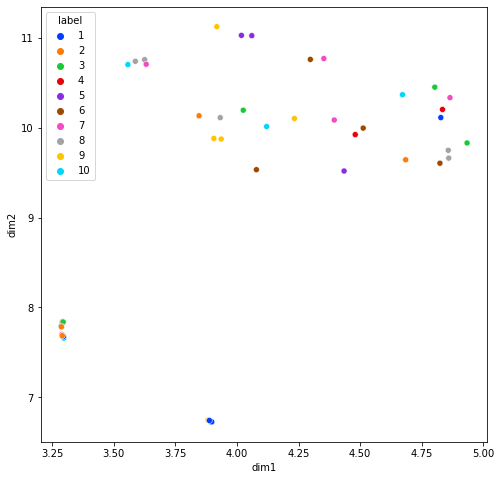

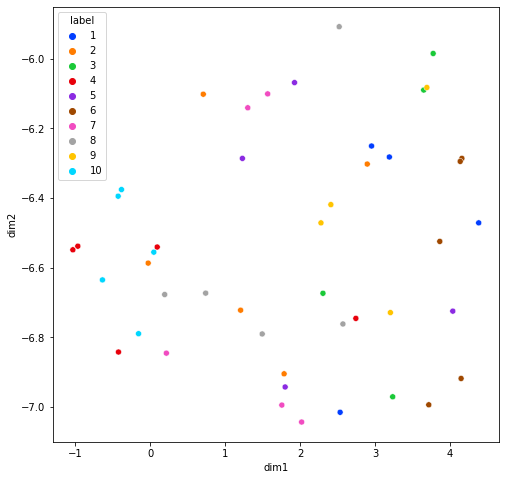

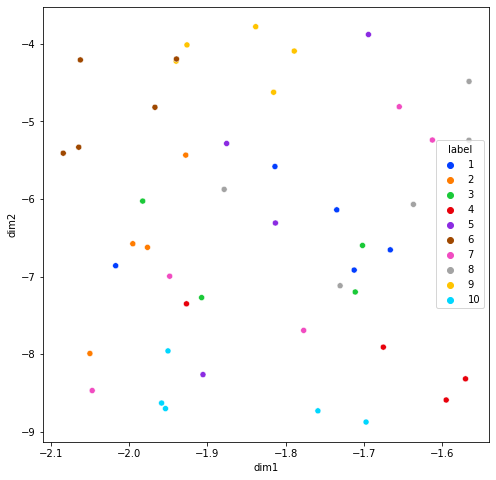

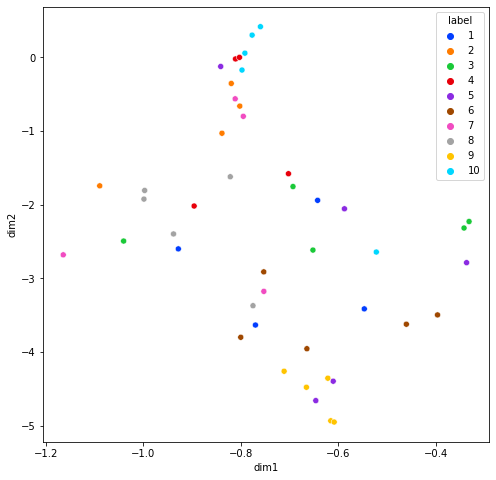

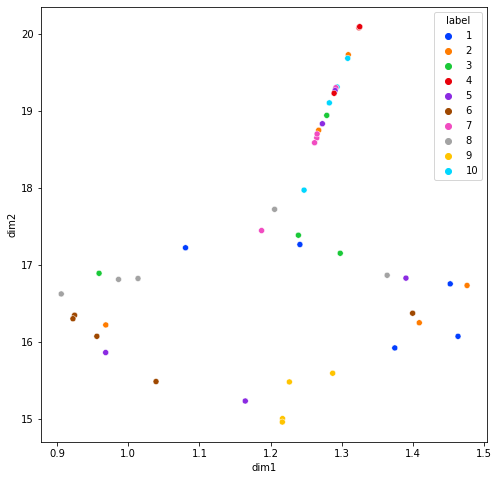

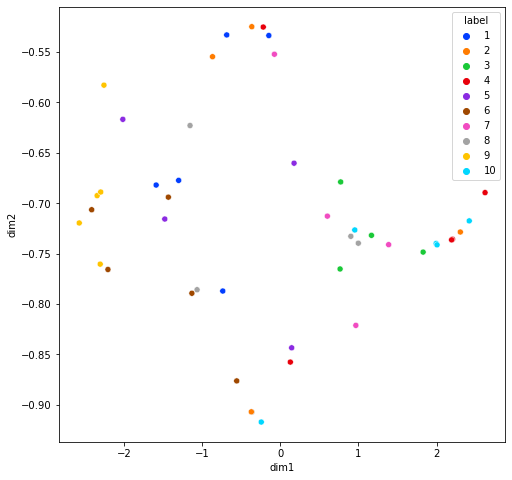

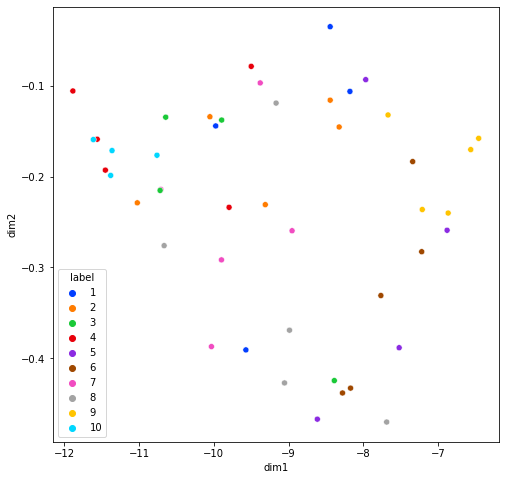

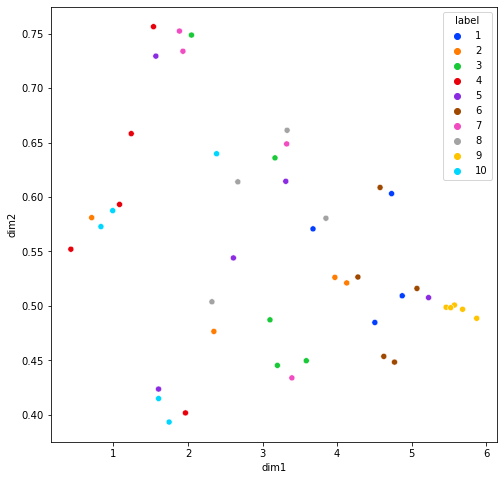

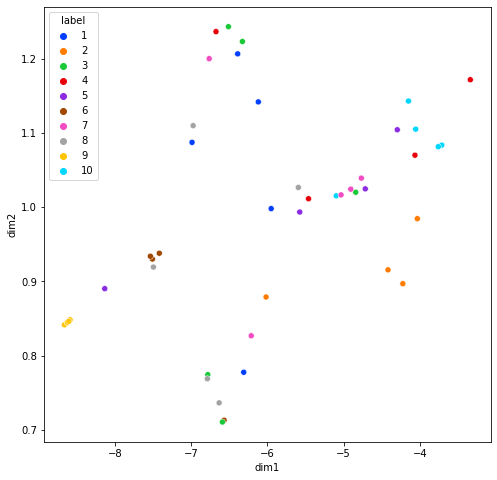

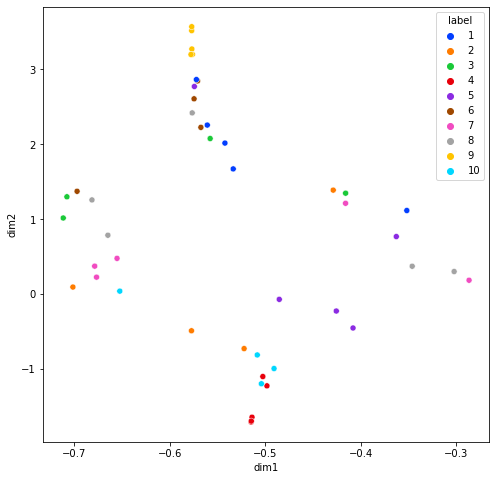

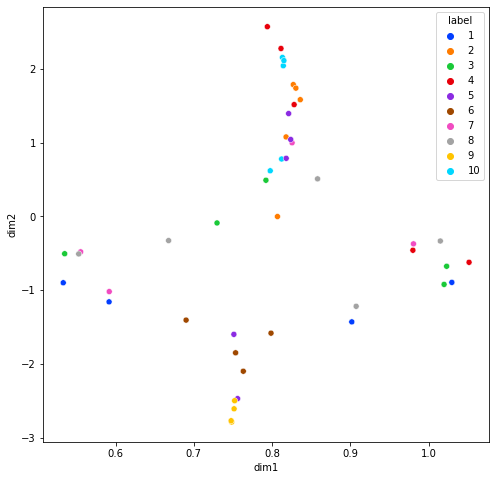

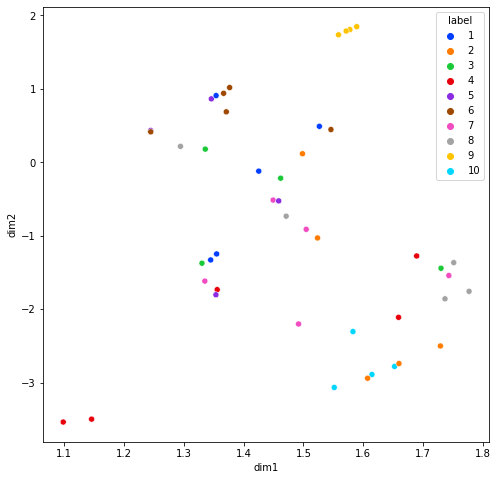

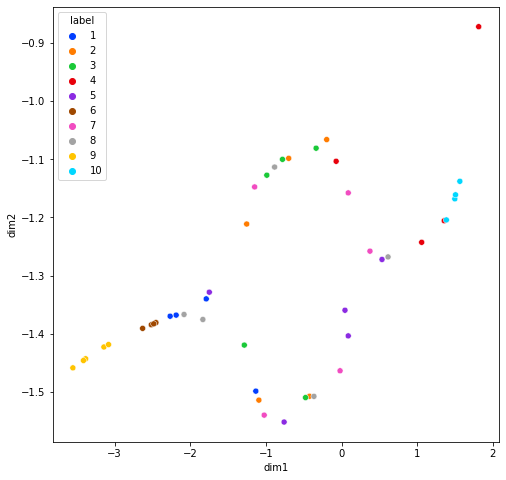

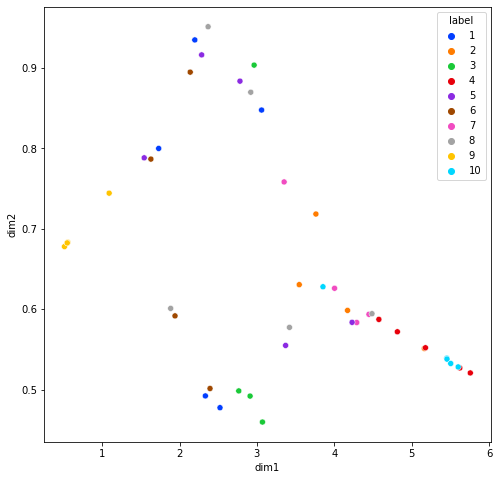

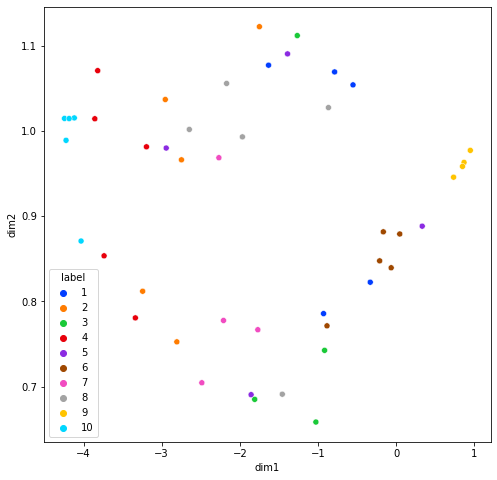

In [81]:
beta = 12.
epochs = 15
latent_dim = 2

dataset_name = "distributed100atoms_dataset"
train_dataset, test_dataset = prepare_data(dataset_name)

train(latent_dim, beta, epochs, train_dataset)#,x_test,dataset_mean,dataset_std)

In [62]:
# func must be function that takes in model, ion, and conc as parameters in this order
def apply_to_dict(func):
    return {model: {ion: {conc: func(model, ion, conc)
                           for conc in CONCS} 
                     for ion in IONS}
             for model in MODEL_N}
MODEL_N = [i for i in range(1, 2)]
IONS = ["Na+", "MG"]
CONCS = [c for c in range(10, 60, 10)]
TIME_FRAMES = [t for t in range(101)]
datafiles = apply_to_dict(lambda m, i, c: f"../data/distance_npz/filtered_sasdfb9_m{m}_{c}_{i}.npz")
npz_dict = apply_to_dict(lambda m, i, c: np.load(datafiles[m][i][c])["arr_0"])

spec_tuple = [(m,i,c,t) for m in MODEL_N for i in IONS for c in CONCS for t in TIME_FRAMES]
# label_map = {f"{m}_{c}_{i}_{t}": 5*int(i=="MG")+int(c/10)  for m in MODEL_N for i in IONS for c in CONCS for t in TIME_FRAMES}
np.random.seed(1)
np.random.shuffle(spec_tuple)
# construct dataset with label shuffled
# label = np.array([str(m)+"_"+str(c)+"_"+i+"_"+str(t) for m,i,c,t in spec_tuple])
label = np.array([5*int(i=="MG")+int(c/10) for m,i,c,t in spec_tuple])
data = np.stack([npz_dict[m][i][c][t] for m, i, c, t in spec_tuple])

# standardization
data = data/np.max(data)
data_mean = np.mean(data)
data_std = np.std(data)
data = (data - data_mean) / (data_std)

# split set into train and test
n_set = len(label)
# split train and test dataset to be 90% and 10% of the entire dataset
split_idx = math.ceil(n_set * 0.9)
# construct train dataset
train_feature_dataset = tf.data.Dataset.from_tensor_slices(data[:split_idx])
train_label_dataset = tf.data.Dataset.from_tensor_slices(label[:split_idx])
train_dataset = tf.data.Dataset.zip((train_feature_dataset, train_label_dataset))
# construct test dataset
test_feature_dataset = tf.data.Dataset.from_tensor_slices(data[split_idx:])
test_label_dataset = tf.data.Dataset.from_tensor_slices(label[split_idx:])
test_dataset = tf.data.Dataset.zip((test_feature_dataset, test_label_dataset))

# save dataset
train_dataset.save(f"../dataset/m1_ssRNA_train_{dataset_name}")
test_dataset.save(f"../dataset/m1_ssRNA_test_{dataset_name}")